In [1]:
import codecs
import math
import random
import string
import time
import numpy as np
import torch
from sklearn.metrics import accuracy_score

'''
Don't change these constants for the classification task.
You may use different copies for the sentence generation model.
'''
languages = ["af", "cn", "de", "fi", "fr", "in", "ir", "pk", "za"]
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


import unicodedata

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = codecs.open(filename, "r",encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/cities/train/*.txt'))


for filename in findFiles('data/cities/train/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/cities/train/in.txt', 'data/cities/train/pk.txt', 'data/cities/train/fr.txt', 'data/cities/train/af.txt', 'data/cities/train/cn.txt', 'data/cities/train/za.txt', 'data/cities/train/fi.txt', 'data/cities/train/ir.txt', 'data/cities/train/de.txt']


we got a dictionary - the keys are the languages and the value is a list of words.
let's look a one list for language 'de':

In [3]:
category_lines['de'][:10]

['rudenweiler',
 'comunidad pallina grande',
 'joao lopes de cima',
 'los aymanes de san miguel',
 'am badeche',
 'hesedorf',
 'lohnerheide',
 'istermyrliden',
 'kleinlellenfeld',
 'hadeth baalbek']

Let examine our data:
how many categories do we have?

In [4]:
n_categories

9

every category is a language, what language do we have in this dataset?

In [5]:
all_categories

['in', 'pk', 'fr', 'af', 'cn', 'za', 'fi', 'ir', 'de']

how many token do we have in each category?

In [6]:
{lang:len(category_lines[lang]) for lang in all_categories}

{'in': 3000,
 'pk': 3000,
 'fr': 3000,
 'af': 3000,
 'cn': 3000,
 'za': 3000,
 'fi': 3000,
 'ir': 3000,
 'de': 3000}

so we have 3000 tokens for each language.

lets look at characters

In [7]:
char={}
for lang in all_categories:
    char[lang]=sum([len(category_lines[lang][word]) for word in range(len(category_lines[lang]))])
    
char

{'in': 33991,
 'pk': 34561,
 'fr': 33448,
 'af': 32537,
 'cn': 28946,
 'za': 33110,
 'fi': 31037,
 'ir': 33172,
 'de': 37377}

In [8]:
print(f'max: {max(char.values())} min: {min(char.values())}')

max: 37377 min: 28946


in all languages we have between 28k to 38k characters


lets see the average of letter in each token:

In [9]:
import statistics
avg= {lang: statistics.mean([len(category_lines[lang][word])  for word in range(3000)]) for lang in all_categories}
avg

{'in': 11.330333333333334,
 'pk': 11.520333333333333,
 'fr': 11.149333333333333,
 'af': 10.845666666666666,
 'cn': 9.648666666666667,
 'za': 11.036666666666667,
 'fi': 10.345666666666666,
 'ir': 11.057333333333334,
 'de': 12.459}

In [10]:
print(f'mean of average char per token in all language is {statistics.mean(avg.values())}')

mean of average char per token in all language is 11.043666666666667


The average of characters per token is similar in almosgt all languages - around 11

In [11]:
diff_char= {lang: set([char for word in range(3000) for char in category_lines[lang][word]]) for lang in all_categories }
diff_char['ir']

{' ',
 "'",
 '.',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [12]:
{lang:len(diff_char[lang]) for lang in diff_char.keys()}

{'in': 29,
 'pk': 29,
 'fr': 29,
 'af': 28,
 'cn': 27,
 'za': 29,
 'fi': 29,
 'ir': 29,
 'de': 29}

we can see that all numbers have almost the same numbers of diffrent characters

In [13]:
print(f'total number of possible letters: {n_letters}')
print(f'all letters :\n {all_letters}')

total number of possible letters: 57
all letters :
 abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


Explain why the unicodeToAscii is a good idea for this task.

# MODEL

In [14]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


#examples

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [15]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [16]:
#example:
input_ = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output_A, next_hidden = rnn(input_, hidden)
print(f'output: {output_A}\n')
print(f'next hidden: {next_hidden}')

output: tensor([[-2.2088, -2.2254, -2.1725, -2.1560, -2.3094, -2.2056, -2.1854, -2.1942,
         -2.1279]], grad_fn=<LogSoftmaxBackward>)

next hidden: tensor([[-0.0848,  0.1130, -0.0428,  0.0427, -0.0641,  0.0289,  0.0894,  0.0039,
          0.0143, -0.0008,  0.0198,  0.0546, -0.0239, -0.0493,  0.0148, -0.0609,
          0.0760, -0.0218,  0.0223, -0.1252,  0.0337,  0.0725,  0.0332,  0.0277,
          0.0048,  0.0059,  0.0168,  0.0148, -0.0359, -0.0543, -0.1065, -0.0003,
          0.0105, -0.1160, -0.0965,  0.0816, -0.0302,  0.0622,  0.0010, -0.1159,
          0.0295, -0.0046, -0.0349, -0.1333,  0.0349,  0.0647, -0.0604,  0.0157,
         -0.0026, -0.0592, -0.0989,  0.0793,  0.0429,  0.0218, -0.0926,  0.0825,
         -0.0397,  0.0275, -0.0336, -0.1199, -0.1005,  0.0793, -0.0264,  0.0163,
         -0.0225, -0.0848,  0.1006,  0.0012,  0.0383,  0.0114, -0.0175,  0.0586,
          0.0255, -0.0019, -0.1032, -0.0293,  0.0385, -0.0051,  0.0395,  0.0043,
          0.0259, -0.0251,  0.0052,  

In [17]:
#example
input_ = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_[0], hidden)
print(f'output: {output}')

output: tensor([[-2.2088, -2.2254, -2.1725, -2.1560, -2.3094, -2.2056, -2.1854, -2.1942,
         -2.1279]], grad_fn=<LogSoftmaxBackward>)


In [18]:
output_A==output

tensor([[True, True, True, True, True, True, True, True, True]])

we got the same tensor for the letter A

In [19]:

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))



('de', 8)


In [20]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/line =', line)

category = fi /line = stor kanskog
category = fi /line = pierrebuffiere
category = ir /line = musa bolaghi
category = cn /line = lisanmiao
category = pk /line = fateh sherwala
category = fi /line = grosselfingen
category = za /line = bahlolzai
category = fr /line = le vezier
category = de /line = oberheise
category = fi /line = pistikivi


In [56]:
category, line, category_tensor, line_tensor=randomTrainingExample()
print(category_tensor)
print(category_tensor.item())
print(category_tensor[0].item())

tensor([6])
6
6



the loss function we use is NLLLoss

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and

   -  Keep hidden state for next letter

-  Compare final output to target
-  Back-propagate
-  Return the output and loss



# Training

In [21]:
#training
criterion = nn.NLLLoss()

learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn


#input=  line_tensor 
#target output= category_tensor
def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()



In [22]:
#example
input_ = lineToTensor('Albert')
category_tensor = torch.tensor([all_categories.index('ir')], dtype=torch.long)

output, loss= train(category_tensor, input_)
print(loss)

2.193152904510498


In [23]:
#example
category, line, category_tensor, line_tensor = randomTrainingExample()
print(category, line)
train(category_tensor, line_tensor )

za arzam


(tensor([[-2.2958, -2.1763, -2.1504, -2.2197, -2.2531, -2.1916, -2.2767, -2.1368,
          -2.0930]], grad_fn=<LogSoftmaxBackward>),
 2.191577672958374)

In [24]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 2.1778 derevlevo / pk ✗ (de)
10000 10% (0m 19s) 2.1991 nyirvasvari / pk ✗ (ir)
15000 15% (0m 29s) 2.1015 dezgaran / ir ✓
20000 20% (0m 39s) 2.2450 kale naqd ali / pk ✗ (ir)
25000 25% (0m 49s) 2.0623 parkumaki / pk ✗ (fi)
30000 30% (0m 59s) 2.0087 zamet / af ✗ (za)
35000 35% (1m 8s) 2.4909 puhakkala / pk ✗ (fi)
40000 40% (1m 17s) 2.5969 boca de uracoa / za ✗ (de)
45000 45% (1m 28s) 1.4135 finsiga / in ✗ (fi)
50000 50% (1m 38s) 0.8734 kengziwei / cn ✓
55000 55% (1m 47s) 0.7626 heronchelle / fr ✓
60000 60% (1m 56s) 2.3229 pote / fr ✗ (za)
65000 65% (2m 6s) 0.5668 holdenseter / de ✓
70000 70% (2m 16s) 0.3245 ghadzabi / za ✓
75000 75% (2m 26s) 1.2444 fotinista / fi ✗ (in)
80000 80% (2m 35s) 1.4887 sapintoen / cn ✗ (in)
85000 85% (2m 44s) 1.1618 karez gholam / af ✓
90000 90% (2m 54s) 0.9292 monfiano / fi ✓
95000 95% (3m 3s) 1.9079 pfalzel / za ✗ (de)
100000 100% (3m 12s) 2.3588 runaubuan / cn ✗ (fr)


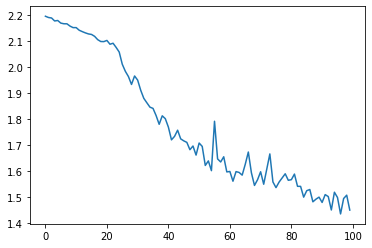

In [25]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

# Evaluating

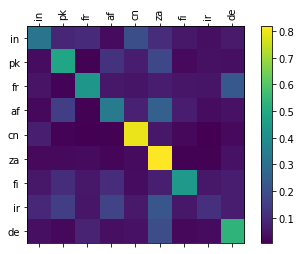

In [26]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [27]:
confusion

tensor([[0.3192, 0.0899, 0.1007, 0.0279, 0.1987, 0.1061, 0.0576, 0.0378, 0.0621],
        [0.0304, 0.4866, 0.0087, 0.1249, 0.0676, 0.1795, 0.0260, 0.0399, 0.0364],
        [0.0453, 0.0111, 0.4366, 0.0555, 0.0500, 0.0675, 0.0546, 0.0500, 0.2294],
        [0.0200, 0.1536, 0.0095, 0.3445, 0.0773, 0.2538, 0.0658, 0.0324, 0.0429],
        [0.0716, 0.0104, 0.0056, 0.0094, 0.7966, 0.0556, 0.0226, 0.0038, 0.0245],
        [0.0250, 0.0232, 0.0285, 0.0143, 0.0285, 0.8200, 0.0080, 0.0098, 0.0428],
        [0.0560, 0.1103, 0.0560, 0.1077, 0.0320, 0.0738, 0.4422, 0.0552, 0.0667],
        [0.0940, 0.1540, 0.0531, 0.1723, 0.0592, 0.2228, 0.0566, 0.1184, 0.0696],
        [0.0374, 0.0209, 0.0844, 0.0383, 0.0426, 0.1958, 0.0209, 0.0261, 0.5335]])

we can see that we have very good results for cn, good results for fr but all other results give us less than 50%.
we can also see that we have mistakes on some languages especially de- fr, pk- ir and af-ir.
these are the results on data from the training set, lets evaluate the prediction on the test dataset.

# predict

In [28]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [29]:
# Build the category_lines dictionary, a list of names per language
category_lines_test = {}
all_categories_test = []

# Read a file and split into lines
def readLines(filename):
    lines = codecs.open(filename, "r",encoding='utf-8', errors='ignore').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

def findFiles(path): return glob.glob(path)

print(findFiles('data/cities/val/*.txt'))


for filename in findFiles('data/cities/val/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories_test.append(category)
    lines = readLines(filename)
    category_lines_test[category] = lines
n_categories_test = len(all_categories_test)

['data/cities/val/in.txt', 'data/cities/val/pk.txt', 'data/cities/val/fr.txt', 'data/cities/val/af.txt', 'data/cities/val/cn.txt', 'data/cities/val/za.txt', 'data/cities/val/fi.txt', 'data/cities/val/ir.txt', 'data/cities/val/de.txt']


In [30]:
all_categories_test

['in', 'pk', 'fr', 'af', 'cn', 'za', 'fi', 'ir', 'de']

In [31]:
def randomTestExample():
    category = randomChoice(all_categories_test)
    line = randomChoice(category_lines_test[category])
    category_tensor = torch.tensor([all_categories_test.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor


def categoryFromOutput_t(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories_test[category_i], category_i

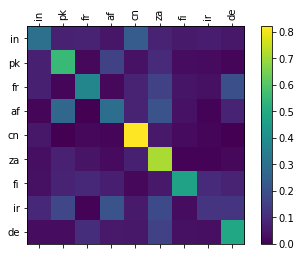

In [32]:
# Keep track of correct guesses in a confusion matrix
confusion_test = torch.zeros(n_categories, n_categories)
n_confusion = 10000


# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTestExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput_t(output)
    category_i = all_categories_test.index(category)
    confusion_test[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories_test):
    confusion_test[i] = confusion_test[i] / confusion_test[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_test.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories_test, rotation=90)
ax.set_yticklabels([''] + all_categories_test)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [33]:
confusion_test

tensor([[0.3018, 0.0759, 0.0804, 0.0482, 0.2384, 0.0777, 0.0580, 0.0661, 0.0536],
        [0.0714, 0.5522, 0.0165, 0.1603, 0.0403, 0.0980, 0.0284, 0.0229, 0.0101],
        [0.0726, 0.0111, 0.3769, 0.0179, 0.0803, 0.1573, 0.0453, 0.0385, 0.2000],
        [0.0141, 0.2723, 0.0000, 0.2953, 0.0822, 0.2095, 0.0389, 0.0080, 0.0796],
        [0.0539, 0.0000, 0.0189, 0.0132, 0.8214, 0.0577, 0.0227, 0.0123, 0.0000],
        [0.0323, 0.0769, 0.0419, 0.0253, 0.0716, 0.7170, 0.0096, 0.0079, 0.0175],
        [0.0360, 0.0802, 0.0919, 0.0694, 0.0189, 0.0550, 0.4748, 0.0964, 0.0775],
        [0.0904, 0.1752, 0.0065, 0.2088, 0.0606, 0.1836, 0.0270, 0.1249, 0.1230],
        [0.0282, 0.0263, 0.1081, 0.0572, 0.0527, 0.1626, 0.0381, 0.0345, 0.4923]])

In [34]:
confusion_test==confusion

tensor([[False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False]])

we got pretty good results

In [35]:
import torch.nn as nn

class RNN_dropout(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_dropout, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(self.dropout(combined))
        output = self.i2o(self.dropout(combined))
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn_dropout = RNN_dropout(n_letters, n_hidden, n_categories)

In [36]:
#training
criterion = nn.NLLLoss()

learning_rate = 0.001 # If you set this too high, it might explode. If too low, it might not learn


#input=  line_tensor 
#target output= category_tensor
def train2(category_tensor, line_tensor):
    hidden = rnn_dropout.initHidden()
    rnn_dropout.zero_grad()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_dropout(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn_dropout.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [37]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train2(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 14s) 2.2047 huanggoudianzi / za ✗ (cn)
10000 10% (0m 29s) 2.1889 cool spring manor / za ✗ (in)
15000 15% (0m 44s) 1.9748 le haut chene / fr ✓
20000 20% (0m 57s) 1.9040 basti ghanjaranwali / pk ✓
25000 25% (1m 10s) 2.1107 lyudinichi / fi ✗ (in)
30000 30% (1m 24s) 2.5287 kani sefid marivan / cn ✗ (fi)
35000 35% (1m 37s) 3.0299 piazza armerina / pk ✗ (in)
40000 40% (1m 51s) 1.6600 kachcha pakka / za ✗ (pk)
45000 45% (2m 4s) 1.0914 sitio alcides marfim / de ✓
50000 50% (2m 18s) 3.1692 ghund / in ✗ (af)
55000 55% (2m 31s) 3.9500 chak one hundred sixtyeightone hundred seventyone nb / cn ✗ (pk)
60000 60% (2m 44s) 2.6010 sangdehe bala / za ✗ (de)
65000 65% (2m 57s) 1.5955 warzachewka / pk ✗ (za)
70000 70% (3m 11s) 2.1337 yujia qiao / pk ✗ (cn)
75000 75% (3m 24s) 1.4991 narmekan / ir ✓
80000 80% (3m 38s) 1.7050 alyakhel / af ✓
85000 85% (3m 52s) 1.9956 bousigniessurroc / in ✗ (fr)
90000 90% (4m 5s) 1.1789 minamisoma / fi ✗ (in)
95000 95% (4m 19s) 1.6072 mahbub jo goth / af ✗ (pk)
10

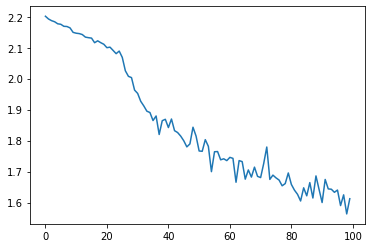

In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

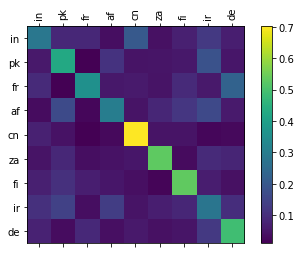

In [39]:
# Keep track of correct guesses in a confusion matrix
confusion2 = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate2(line_tensor):
    hidden = rnn_dropout.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn_dropout(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate2(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion2[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion2[i] = confusion2[i] / confusion2[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion2.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()